In [1]:
import os
import pandas as pd

import sys; sys.path.append("..") # Adds parent directory to python modules path.
from topdown_parsers import *

import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import geopandas as gpd
from sklearn.linear_model import LinearRegression

from ER_noise import *

In [7]:
# csv_dir_without_hhs = "er_csvs/runs_without_hhs"
# csv_dir_with_hhs = "er_csvs/runs_with_hhs"
csv_dir_without_hhs = "er_csvs/gaussian_runs_without_hh"

epsilon_values = ["0.25", "0.5", "1", "2"]
epsilon_splits = ["equal", "bottom-heavy", "mid-heavy", "top-heavy"]

In [3]:
runoff_filepath = "DallasCounty_elects.csv"
runoff_file = pd.read_csv(runoff_filepath)

runoff_file["President_12G_ObamaD_pct"] = runoff_file["President_12G_ObamaD"] / runoff_file["President_12G_Total"]
runoff_file["President_12G_ObamaD_pct"] = runoff_file["President_12G_ObamaD_pct"].fillna(0)

runoff_file["Comptroller_18G_ChevalierD_pct"] = runoff_file["Comptroller_18G_ChevalierD"] / runoff_file["Comptroller_18G_Total"]
runoff_file["Comptroller_18G_ChevalierD_pct"] = runoff_file["Comptroller_18G_ChevalierD_pct"].fillna(0)

In [4]:
obama = {
    "name"          : "Obama",
    "election_name" : "2012 General Presidential",
    "perc_col"      : "President_12G_ObamaD_pct",
    "tot_votes"     : "President_12G_Total"
    
}

valdez = {
    "name"          : "Valdez",
    "election_name" : "TX Statewide 2018 Dem Runoff Governor",
    "perc_col"      : "ValdezD_18R_Governor_pct",
    "tot_votes"     : "18R_Governor_D_tot" 
}

chevalier = {
    "name"          : "Chevalier",
    "election_name" : "Comptroller 2018 General",
    "perc_col"      : "Comptroller_18G_ChevalierD_pct",
    "tot_votes"     : "Comptroller_18G_ChevalierD"
}

candidate_configs = [valdez, obama, chevalier]

In [16]:
def label_split_and_budget(df, eps_split, eps_budget):
    """
    """
    if eps_split == "mid":
        df["split"] = "mid-heavy"
    elif eps_split == "top":
        df["split"] = "top-heavy"
    elif eps_split == "bottom":
        df["split"] = "bottom-heavy"
    elif eps_split == "eq":
        df["split"] = "equal"
    else:
        raise ValueError("Split value is {}, but was expecting one of [equal, top, mid, heavy]".format(eps_split))
        
    if eps_budget == "0pt25":
        df["epsilon"] = "0.25"
    elif eps_budget == "0pt5":
        df["epsilon"] = "0.5"
    elif eps_budget == "1":
        df["epsilon"] = "1"
    elif eps_budget == "2":
        df["epsilon"] = "2"
    else:
        raise ValueError("Budget value is {}, but was expecting one of [0pt25, 0pt5, 1, 2]".format(eps_budget))
        
    return df
    
def add_runoff(runoff, df, precinct_col="Precinct"):
    """ Adds the vote data in `runoff` to `df`.
    """
    runoff = runoff[runoff["CNTYVTD"].isin(df[precinct_col])] # only keeping dallas
    
    df = df.merge(runoff, how="left", left_on="Precinct", right_on="CNTYVTD")
    return df
    
def combine_csvs(csv_dir, runoff_file, with_hh):
    """ Combines all the csvs in `csv_dir`, labels their budget and split, and then 
        merges the `runoff_filepath` file to it to combine vote data.
        `with_hh` is a Bool that is True if the csvs are runs with Household Constraints.
    """
    dfs = []
    
    for root, dirs, files in os.walk(csv_dir):
        for file in files:
            
            if os.path.splitext(file)[1] != ".csv":
                continue
            
            if with_hh: 
                eps_split = file[:-4].split("_")[3]
                eps_budget = file[:-4].split("_")[4]
            else:
                eps_split = file[:-4].split("_")[2]
                eps_budget = file[:-4].split("_")[3]
            
            df = pd.read_csv(os.path.join(root, file))
            df = label_split_and_budget(df, eps_split, eps_budget)
            df = add_runoff(runoff_file, df)
            
            dfs.append(df)
    
    main_df = pd.concat(dfs)
    
    return main_df

def plot_er_and_point_estimates(df, epsilon_values, epsilon_splits, race, candidate_configs, with_hh=False):
    """
    """
    save_hh_str = "with_hh" if with_hh else "without_hh"
    title_hh_str = "with HH constraints" if with_hh else "without HH constraints"
    
    sigma_matches = pd.read_csv("topdown_expected_l1_error_pcts_recon_and_matching_sigma.csv")
    sigma_matches["sigma"] = sigma_matches["sigma"]
    
    # gaussian 
    for candidate in candidate_configs:
        print(candidate["name"])
        plot_elect_grid_gaussian_noise(epsilon_values, 
                                       epsilon_splits, 
                                       df, 
                                       candidate["name"], 
                                       race, 
                                       candidate["perc_col"],
                                       candidate["tot_votes"],
                                       sigma_matches, 
                                       hh=with_hh, 
                                       figsize=(20,20), 
                                       filt=True,
                                       title=None, 
                                       weight=False, 
                                       n_samps=20)
        
    return

    # configs
    settings = ["weight", "filter", "no_filter"]
    for candidate in candidate_configs:
        for sett in settings:
            if sett == "weight":
                title_sett_str = "weighted"; save_sett_str = "weighted"; weight = True; filt = False
            elif sett == "filter":
                title_sett_str = "filter at thresh=10"; save_sett_str = "filt_10"; weight = False; filt = True
            else:
                title_sett_str = "no_filter"; save_sett_str = "no_filt"; weight = False; filt = False

            # ER
            fig, axs = plot_elect_grid(epsilon_values, 
                                       epsilon_splits, 
                                       df, 
                                       candidate["name"],
                                       race, 
                                       candidate["perc_col"],
                                       candidate["tot_votes"],
                                       figsize=(20,20), 
                                       filt=filt, 
                                       weight=weight, 
                                       n_samps=20, 
                                       title="ER: Votes for {}: {} | " 
                                             "TopDown Noise with {}, {}".format(candidate["name"], 
                                                                                candidate["election_name"],
                                                                                title_sett_str, 
                                                                                title_hh_str)
                                      )
            plt.savefig("TopDown_{}_{}_{}_er_{}.png".format(race, save_sett_str, save_hh_str,candidate["name"]), dpi=300)

            # Point estimates
            fig, axs = plot_point_estimate_grid(epsilon_values, 
                                                epsilon_splits, 
                                                df, 
                                                candidate["name"],
                                                race, 
                                                candidate["perc_col"],
                                                candidate["tot_votes"], 
                                                figsize=(20,20), 
                                                filt=filt, 
                                                weight=weight, 
                                                n_samps=20,
                                                title="Point Estimates: Votes for {}: {} | "
                                                      "TopDown Noise with {}, {}".format(candidate["name"], 
                                                                                         candidate["election_name"],
                                                                                         title_sett_str, 
                                                                                         title_hh_str),
                                                x_lims=(0,1)
                                               )
            plt.savefig("TopDown_{}_{}_{}_point_estimates_{}.png".format(race, save_sett_str, save_hh_str, candidate["name"]), dpi=300)
            

In [ ]:
df_without_hhs = combine_csvs(csv_dir_without_hhs, runoff_file, False)
df_with_hhs = combine_csvs(csv_dir_with_hhs, runoff_file, True)

plot_er_and_point_estimates(df_without_hhs, epsilon_values, epsilon_splits, "HVAP", candidate_configs, with_hh=False)
plot_er_and_point_estimates(df_without_hhs, epsilon_values, epsilon_splits, "BVAP", candidate_configs, with_hh=False)
plot_er_and_point_estimates(df_without_hhs, epsilon_values, epsilon_splits, "WVAP", candidate_configs, with_hh=False)

plot_er_and_point_estimates(df_with_hhs, epsilon_values, epsilon_splits, "HVAP", candidate_configs, with_hh=True)
plot_er_and_point_estimates(df_with_hhs, epsilon_values, epsilon_splits, "BVAP", candidate_configs, with_hh=True)
plot_er_and_point_estimates(df_with_hhs, epsilon_values, epsilon_splits, "WVAP", candidate_configs, with_hh=True)

Valdez
Obama
Chevalier


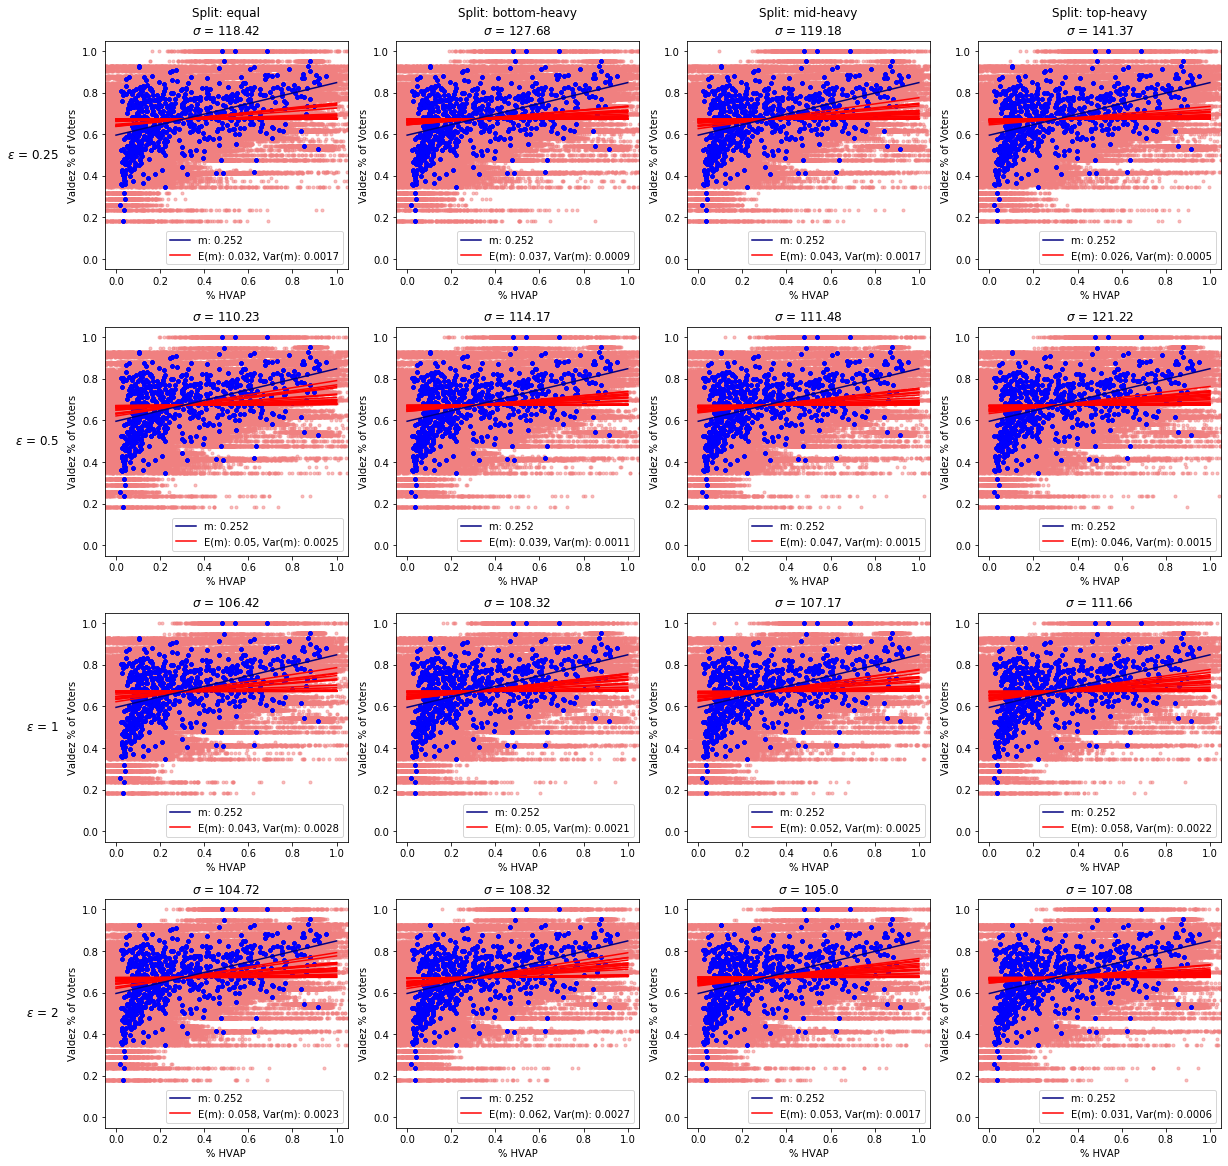

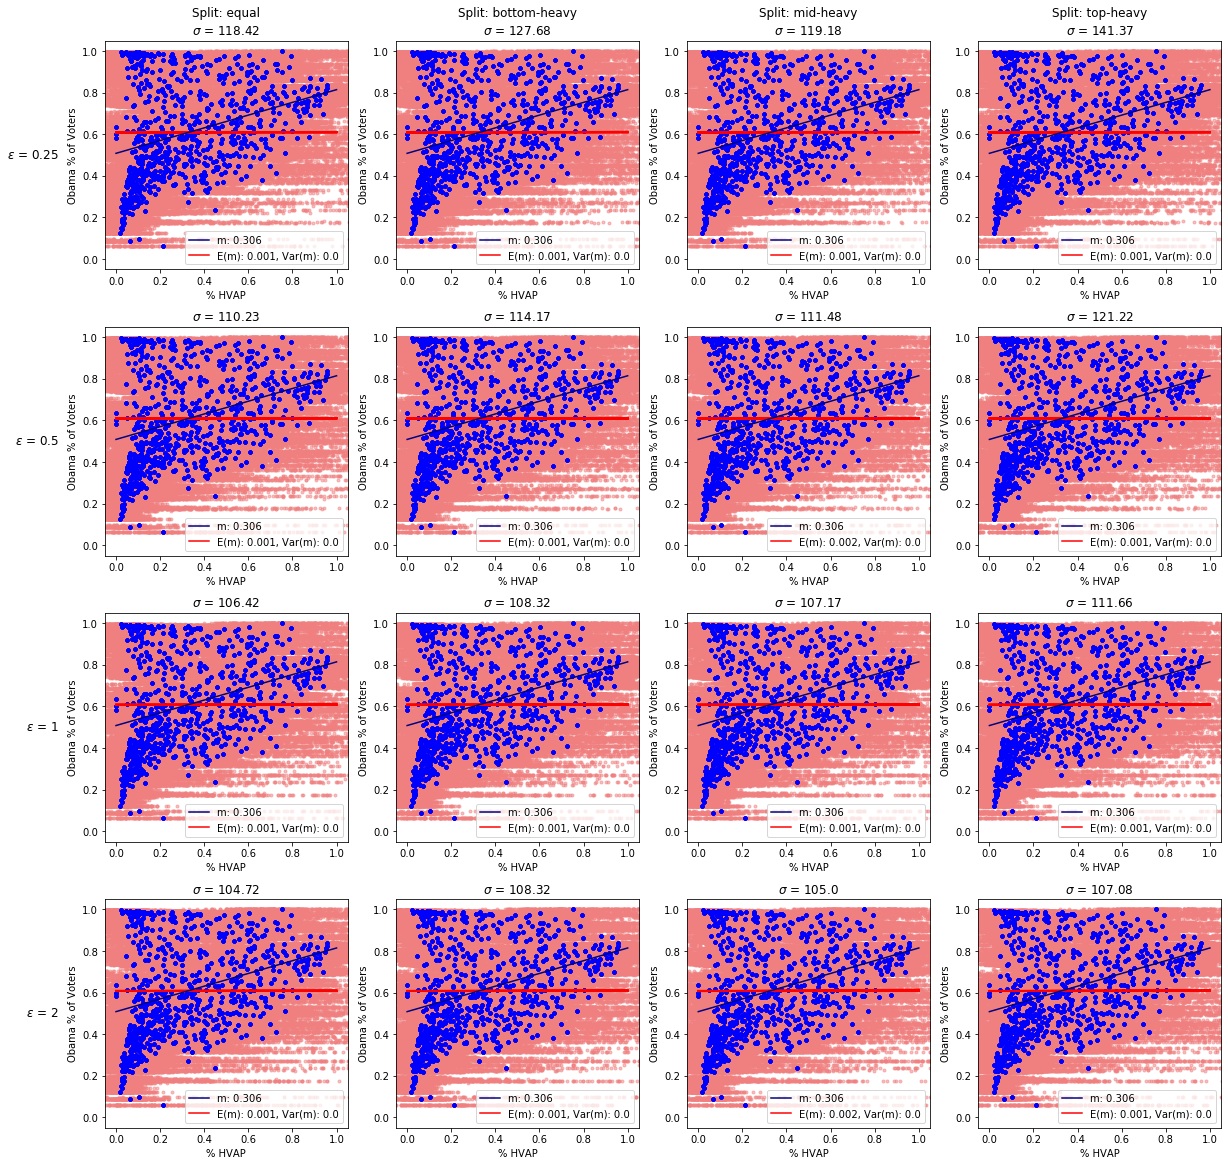

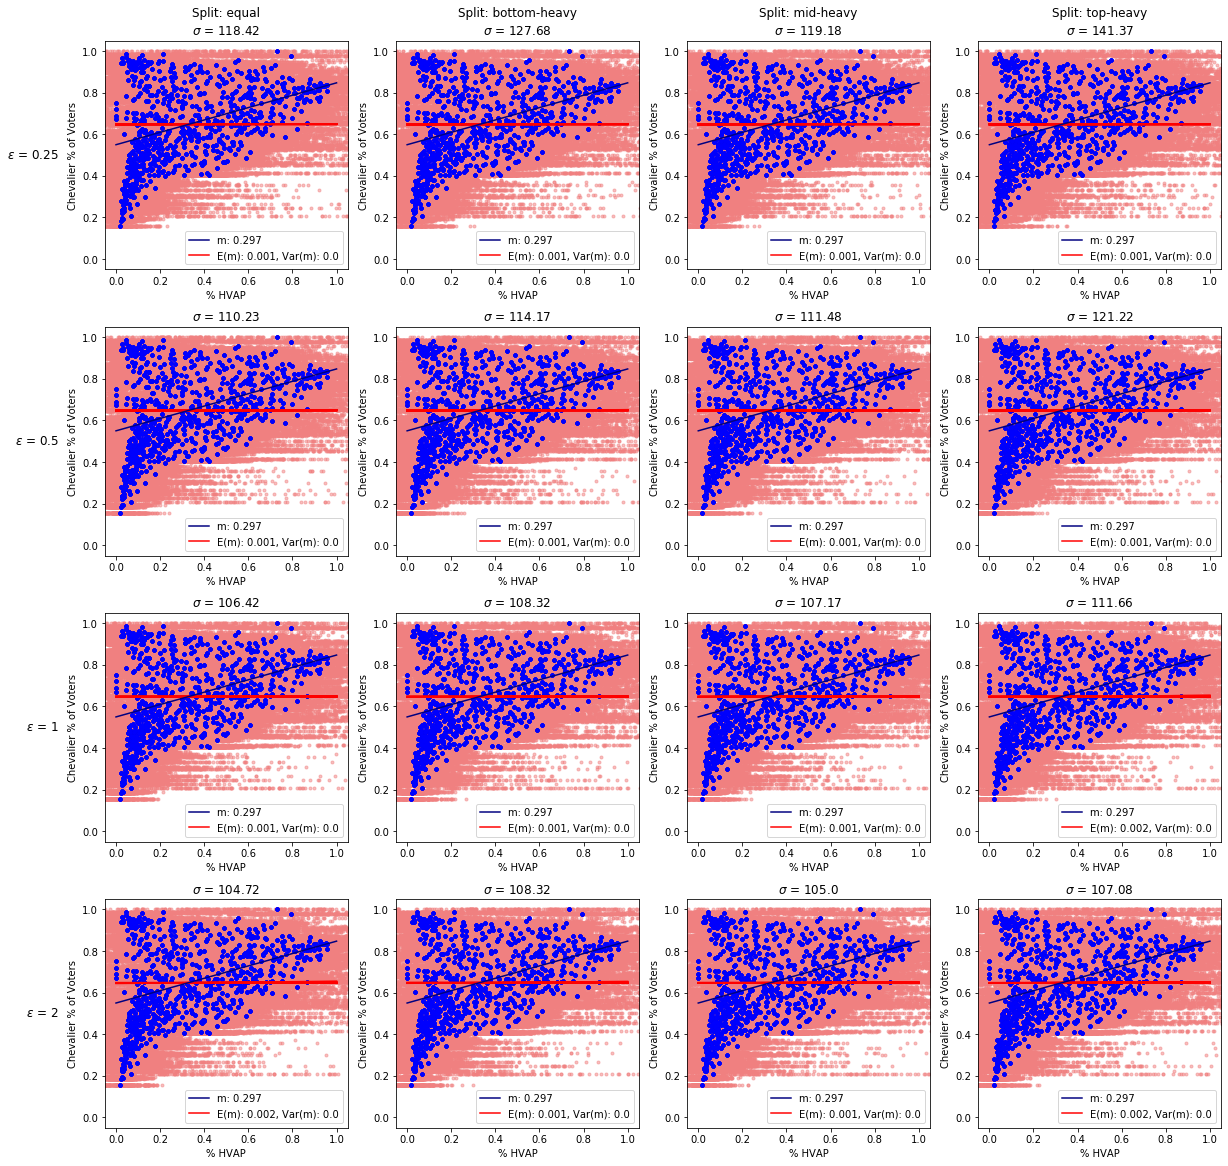

In [17]:
df_without_hhs = combine_csvs(csv_dir_without_hhs, runoff_file, False)
plot_er_and_point_estimates(df_without_hhs, epsilon_values, epsilon_splits, "HVAP", candidate_configs, with_hh=False)

In [9]:
sigma_matches = pd.read_csv("topdown_expected_l1_error_pcts_recon_and_matching_sigma.csv")
sigma_matches

,eps,split,hh,L1_error,sigma
0,0.25,bottom-heavy,False,1179477.70,127.678017
1,0.25,bottom-heavy,True,1239273.85,134.150927
2,0.25,equal,False,1093922.70,118.416720
3,0.25,equal,True,1124127.70,121.686400
4,0.25,mid-heavy,False,1100985.90,119.181309
5,0.25,mid-heavy,True,1118533.20,121.080797
6,0.25,top-heavy,False,1305999.00,141.373900
7,0.25,top-heavy,True,1374816.20,148.823336
8,0.50,bottom-heavy,False,1054684.20,114.169167
9,0.50,bottom-heavy,True,1082819.05,117.214754
